In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decpomdp import DecPOMDP
import time
import random
import os
from constant import Constants
import gc 
gc.enable()


In [2]:
#set problem 
file_name = "dectiger"
planning_horizon = 5
num_iterations = 1
sota_ = False
game_type = "zerosum"


problem = DecPOMDP(file_name,horizon=planning_horizon)
Constants.initialize(problem)
constant = Constants.get_instance()
from pbvi import PBVI
from experimentFunctions import Experiment
experiment = Experiment(planning_horizon,problem,algorithm="max_plane")
print(f"game size :\n\t|S| = {len(problem.states)} , {problem.states}")
print(f"\t|Z| = {problem.num_joint_observations} , {problem.joint_observations}\n\t|U| = {constant.JOINT_ACTIONS} with |U_i| = {problem.num_actions[0]}")
print(f"intiial_belief : {problem.b0}\nactions : {problem.joint_actions}")



game size :
	|S| = 2 , ['tiger-left', 'tiger-right']
	|Z| = 4 , [('hear-left', 'hear-left'), ('hear-left', 'hear-right'), ('hear-right', 'hear-left'), ('hear-right', 'hear-right')]
	|U| = [0, 1, 2, 3, 4, 5, 6, 7, 8] with |U_i| = 3
intiial_belief : [0.5 0.5]
actions : [('listen', 'listen'), ('listen', 'open-left'), ('listen', 'open-right'), ('open-left', 'listen'), ('open-left', 'open-left'), ('open-left', 'open-right'), ('open-right', 'listen'), ('open-right', 'open-left'), ('open-right', 'open-right')]


In [3]:
a = {0 : {0},1 :{0}}
if 0 in a[0]:
    print("yes")

yes


In [4]:
#see reward matrix of both player
print(f"REWARD MATRIX OF {game_type} {problem.name} GAME")
print("\nLeader :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][0],columns=problem.states)}")
print("\nFollower :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][1],columns=problem.states)}")

r = constant.REWARDS[game_type][1]
two_d_vectors = np.zeros((len(constant.STATES),len(constant.JOINT_ACTIONS)))
for state in constant.STATES:
    for joint_action in constant.JOINT_ACTIONS:
        two_d_vectors[state][joint_action] = r[joint_action][state]
        print(f"{r[joint_action][state]}")
two_d_vectors

REWARD MATRIX OF zerosum dectiger GAME

Leader :
   tiger-left  tiger-right
0        -2.0         -2.0
1      -101.0          9.0
2         9.0       -101.0
3      -101.0          9.0
4       -50.0         20.0
5      -100.0       -100.0
6         9.0       -101.0
7      -100.0       -100.0
8        20.0        -50.0

Follower :
   tiger-left  tiger-right
0         2.0          2.0
1       101.0         -9.0
2        -9.0        101.0
3       101.0         -9.0
4        50.0        -20.0
5       100.0        100.0
6        -9.0        101.0
7       100.0        100.0
8       -20.0         50.0
2.0
101.0
-9.0
101.0
50.0
100.0
-9.0
100.0
-20.0
2.0
-9.0
101.0
-9.0
-20.0
100.0
101.0
100.0
50.0


array([[  2., 101.,  -9., 101.,  50., 100.,  -9., 100., -20.],
       [  2.,  -9., 101.,  -9., -20., 100., 101., 100.,  50.]])

In [5]:
values,times ,tabular_value , policy= experiment.run_single_experiment(density=0.000001,gametype=game_type,limit=1000,sota=False,iterations=num_iterations)
values

			 Solving zerosum dectiger GAME WITH SOTA False 5 
{0: {0}, 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set()}
	belief expansion done, belief space size = 11

[{0}, {0, 1, 2}, {0, 1, 2, 3, 4}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6, 7, 8}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, set()]
iteration : 1

========== Backup at timestep 4 done, veryfing calulations for next timestep backup ==========
belief = 0 ,   max_plane value (-74.99999999999999, 74.99999999999999) , tabular  (-74.99999999999999, 74.99999999999999)
belief = 1 ,   max_plane value (-66.48489932885906, 66.48489932885906) , tabular  (-66.48489932885906, 66.48489932885906)
belief = 2 ,   max_plane value (-66.48489932885906, 66.48489932885906) , tabular  (-66.48489932885907, 66.48489932885907)
belief = 3 ,   max_plane value (-65.95506088371091, 65.95506088371091) , tabular  (-65.95506088371091, 65.95506088371091)
belief = 4 ,   max_plane value (-65.9550608837109, 65.9550608837109) , tabular  (-65.95506088371091, 65

[(-75.0, 75.0)]

In [6]:
policy[game_type][False][0].print_trees()

SyntaxError: unterminated string literal (detected at line 1) (3704481757.py, line 1)

In [ ]:
database, matrix , policy= experiment.run_experiments(num_iterations,density=0.00001)
pd.DataFrame(database)

			 Solving cooperative broadcastChannel GAME WITH SOTA True 1 
{0: {0}, 1: set(), 2: set()}
	belief expansion done, belief space size = 4

[{0}, {0, 1, 2, 3}, set()]
iteration : 1

========== Backup at timestep 0 done, veryfing calulations for next timestep backup ==========
belief = 0 ,   max_plane value (1.0000000000000002, 1.0000000000000002) , tabular  (1.0000000000000002, 1.0000000000000002)





================================================= END OF cooperative GAME WITH SOTA True ======================================================================

			point value at initial belief  (1.0000000000000002, 1.0000000000000002)
			alphavectors value at inital belief (V0,V1) : (1.0000000000000002, 1.0000000000000002)


			 Solving cooperative broadcastChannel GAME WITH SOTA True 2 
{0: {0}, 1: set(), 2: set(), 3: set()}
	belief expansion done, belief space size = 9

[{0}, {0, 1, 2, 3}, {0, 1, 2, 3, 4, 5, 6, 7, 8}, set()]
iteration : 1

========== Backup at timestep 1 done, veryfin

SystemExit: 

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:183: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.database[self.database["gametype"]==gametype][self.database["horizon"]==self.planning_horizon]


TypeError: 'NoneType' object cannot be interpreted as an integer

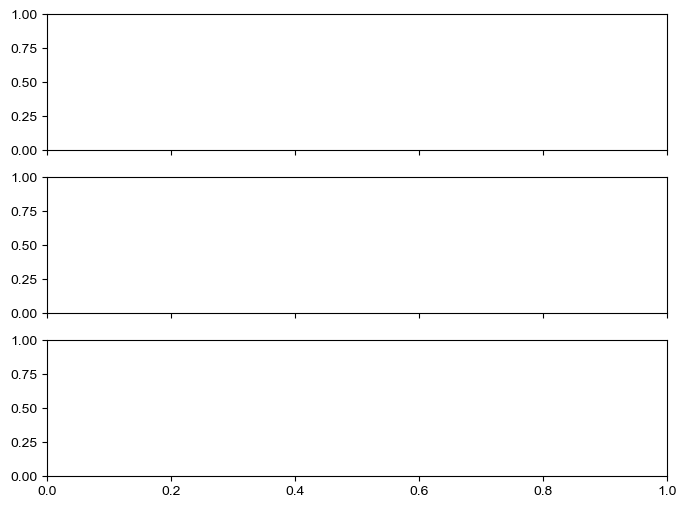

In [ ]:
experiment.plots()
experiment.horizon_value_plot()

In [ ]:
experiment.generate_summary_table()

/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_

{'cooperative':           State of the Art                                                    \
                       time                                   value iteration   
 relay4(0)         0.933659  (7.409999999999998, 7.409999999999998)         3   
 relay4(1)         0.923161  (7.409999999999998, 7.409999999999998)         3   
 relay4(2)         0.922331  (7.409999999999998, 7.409999999999998)         3   
 relay4(3)         0.901461  (7.409999999999998, 7.409999999999998)         3   
 
                PBVI                                                    
                time                                   value iteration  
 relay4(0)  4.709343  (7.409999999999998, 7.409999999999998)         3  
 relay4(1)  4.689476  (7.409999999999998, 7.409999999999998)         3  
 relay4(2)  4.711464  (7.409999999999998, 7.409999999999998)         3  
 relay4(3)  4.664090  (7.409999999999998, 7.409999999999998)         3  ,
 'zerosum':           State of the Art                    